In [91]:
import numpy as np
import scipy
from scipy import integrate, interpolate
from scipy.misc import derivative
from scipy.special import comb
import matplotlib
import copy
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import utilities_simple as utilities
from chainconsumer import ChainConsumer

In [92]:
c = 299792.458           #km/s
GN = 6.674e-11     #m^3/kg/s^2
Msolar = 1.989e30  # kg
Mpc = 3.086e19     # km

In [93]:
cosmo_params = {
...     'OmegaM' : 0.2999,
...     'OmegaDE': 0.7,
...     'OmegaR' : 1.e-4,
...     'h'     : 0.7,
... }

In [94]:
# Define function to return covariance matrix for chosen waveform.

def Fisher_det(farr, pars, psd, cosmo_params, which_wf='GR', MG_flag=False, width=0, distcorr=True):
    
    if which_wf=='GR':
        waveform = utilities.waveform
    elif which_wf=='EFT':
        waveform = utilities.waveform_delta(cT_type='EFT').h_Delta_exact
    elif which_wf=='step':
        waveform = utilities.waveform_delta(cT_type='step', width=width).h_Delta_exact
    
    if distcorr==False:
        hf = waveform(farr, pars, cosmo_params,False)
    else:      
        hf = waveform(farr, pars, cosmo_params)

    dh_dlnMz_func = lambda lnMz_func: waveform(farr, [lnMz_func, pars[1], pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params)
    dh_dlnMz = derivative(dh_dlnMz_func, pars[1], dx=pars[1]*1.e-8)

    # numerical derivatives w.r.t. lneta
    dh_dlneta_func = lambda lneta_func: waveform(farr, [pars[0], lneta_func, pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params)
    dh_dlneta = derivative(dh_dlneta_func, pars[0], dx=pars[0]*1.e-4)

    # numerical derivatives w.r.t. lnz
    dh_dlnz_func = lambda lnz_func: waveform(farr, [pars[0], pars[1], lnz_func, pars[3], pars[4], pars[5], pars[6]], cosmo_params)
    dh_dlnz = derivative(dh_dlnz_func, pars[2], dx=np.log(zem)*1.e-6)

#     dh_dlnDl_func = lambda lnDl_func: utilities.waveform(farr_ligo, [pars[0], pars[1], pars[2], pars[3], pars[4], lnDl_func], cosmo_params, which_wf)
#     dh_dlnDl = derivative(dh_dlnDl_func, pars[5], dx=np.log(Dl)*1.e-3)

    #dh_dtc_func = lambda tc_func: waveform(farr, [pars[0], pars[1], pars[2], tc_func, pars[4], pars[5], pars[6]], cosmo_params)
    #dh_dtc = derivative(dh_dtc_func, pars[3], dx=1.e-3)
    dh_dtc = 2.j*np.pi*farr*waveform(farr, pars, cosmo_params)


    # numerical derivatives w.r.t. psic
    #dh_dpsic_func = lambda psic_func: waveform(farr, [pars[0], pars[1], pars[2], pars[3], psic_func, pars[5], pars[6]], cosmo_params)
    #dh_dpsic = derivative(dh_dpsic_func, pars[4], dx=1.e-3)
    dh_dpsic = -1.j*waveform(farr, pars, cosmo_params)

    dh_dc0_func = lambda c0_func: waveform(farr, [pars[0], pars[1], pars[2], pars[3], pars[4], c0_func, pars[6]], cosmo_params)
    dh_dc0 = derivative(dh_dc0_func, pars[5], dx=1.e-6)

    print(dh_dtc.shape,dh_dpsic.shape,dh_dlnMz.shape)

    if MG_flag==True:
        derivatives = [dh_dlnMz, dh_dlneta, dh_dlnz, dh_dtc, dh_dpsic, dh_dc0]
    else:
        derivatives = [dh_dlnMz, dh_dlneta, dh_dlnz, dh_dtc, dh_dpsic]

    nparams = len(derivatives)

    plabels = ['lnMz','lneta','lnz','tc','psic', 'c0']

    Fisher_matrix = np.zeros((nparams,nparams))

    for i in range(0,nparams):
        for j in range(0,nparams):
            Fisher_matrix[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], psd, farr)

    connum = np.linalg.cond(Fisher_matrix)
    print('condition number (div by 1e15)',connum/1.e15)

    cov_matrix = np.linalg.inv(Fisher_matrix)

    return cov_matrix
    #return Fisher_matrix

In [95]:
# Def plotting function. Define figure first with:
    # fig = plt.figure(figsize=(20,20))
    # gs = gridspec.GridSpec(nparams-1, nparams-1, hspace=0, wspace=0)

def add_fisher_plots(covmat,fid_vals,labels,leg_label,colour):
    alpha = 1.52            #For 1 sigma

    nparams = len(fid_vals)

    for i in range(0,nparams-1):
        for j in range(1+i,nparams):

            ax = plt.subplot(gs[i+(nparams-1)*(j-1)])
            axis_swap = False       # Default is false.

            # Fisher forecast
            a,b, theta_deg = utilities.ellipse_para(covmat[i,i], covmat[j,j], covmat[i,j]) 
            a1sig, b1sig = alpha*a, alpha*b
            
            if (covmat[j,j]>covmat[i,i]):
                theta_deg +=90
                axis_swap = True
            
            rho = covmat[i,j] / np.sqrt(covmat[i,i]* covmat[j,j])

            contour = Ellipse((fid_vals[i],fid_vals[j]), 2.*a1sig, 2.*b1sig, theta_deg, fill=False, color=colour,label=r'$\rho=%.3f$'%rho)

            ax.add_patch(contour)

            if j==(nparams-1):
                ax.set_xlabel(labels[i], fontsize=20)
                plt.xticks(fontsize=20)
            else:
                ax.set_xticklabels([], fontsize=20)

            if i==0:    
                ax.set_ylabel(labels[j], fontsize=20)
                plt.yticks(fontsize=20)
            else:
                ax.set_yticklabels([], fontsize=20)
            
            space_fac = 1.5    #just to pad some white space around the ellipses

            ax.set_xlim(fid_vals[i]-space_fac*alpha*np.sqrt(covmat[i,i]), fid_vals[i]+space_fac*alpha*np.sqrt(covmat[i,i]))
            ax.set_ylim(fid_vals[j]-space_fac*alpha*np.sqrt(covmat[j,j]), fid_vals[j]+space_fac*alpha*np.sqrt(covmat[j,j]))
            
            ax.legend(fontsize=5, loc=2)
       

In [96]:
#Read in and interpolate LIGO and LISA PSDs.
ligo_asd = np.genfromtxt('../data/lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain = np.loadtxt('../data/LISA_strain.txt')

ligo_interp = interpolate.interp1d(ligo_asd[:,0],ligo_asd[:,1])
lisa_interp = interpolate.interp1d(LISA_strain[:,0], LISA_strain[:,3])

In [97]:
#GW150914 parameters
m1 = 36       #solarmass
m2 = 29

Dl = 410      #Mpc
zem = 0.09

time = 2*365*24*3600    # time before merger in sec

tc = 0
psic = 0

In [98]:
# Get mass quantities
m_eff = m1*m2/(m1+m2)
Ms = m_eff**(3./5) * (m1+m2)**(2./5)     # source chirp mass in solarmass
eta = ((m1+m2)/Ms)**(-5./3)

Dl_s = Dl*Mpc/c        # Dl in sec

Ms_s = Ms * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.

# Get frequency ranges for inspiral and plots
f_start = (5*Ms_s/256/time)**(3./8) / np.pi/Ms_s      # starting frequency at the time before merger
f_cut = utilities.get_freq(Mtot_s, eta, "cut")       # End of IMR template
fc = utilities.inspiral_fc(Mtot_s)
farr = np.logspace(np.log10(f_start),np.log10(fc),num=500)  #inspiral range only
f_plot = np.logspace(np.log10(f_start),np.log10(f_cut),num=500)     # full IMR waveform

Dl_arr = np.array([Dl_s]*len(farr))

In [99]:
print('eta',eta)
print('fc',fc)

eta 0.24710059171597634
fc 67.63181124855085


In [100]:
#Waveforms for inspiral and IMR, in GR
pars_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]

h_GR = utilities.waveform(farr, pars_GR, cosmo_params)
h_plot = utilities.waveform(f_plot, pars_GR, cosmo_params)

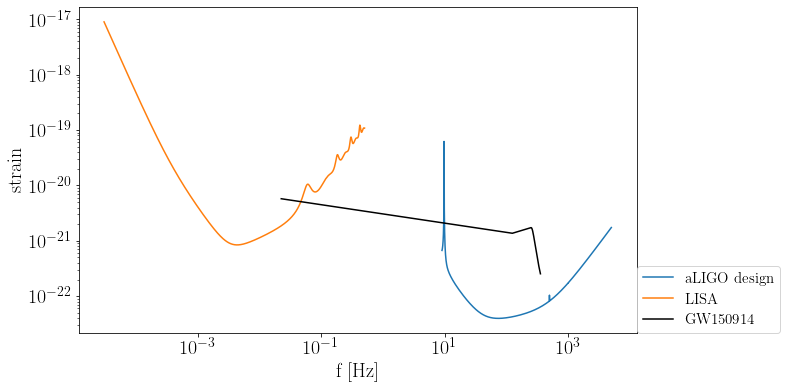

In [101]:
# Plot full IMR GR signal
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(f_plot, np.abs(f_plot*h_plot), color='k', label='GW150914')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, loc=(1,0))

In [102]:
# Get waveform segments in LISA and LIGO ranges only.
farr_ligo = np.logspace(np.log10(ligo_asd[0,0]),np.log10(fc),num=500)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=500)

ligo_psd = ligo_interp(farr_ligo)**2
lisa_psd = lisa_interp(farr_lisa)

h_GR_ligo = utilities.waveform(farr_ligo, pars_GR, cosmo_params)
h_GR_lisa = utilities.waveform(farr_lisa, pars_GR, cosmo_params)


In [103]:
# SNR in LISA and LIGO
SNR_ligo_sq = utilities.scalar_product(h_GR_ligo, h_GR_ligo, ligo_psd, farr_ligo)
SNR_ligo = np.sqrt(SNR_ligo_sq)

SNR_lisa_sq = utilities.scalar_product(h_GR_lisa, h_GR_lisa, lisa_psd, farr_lisa)
SNR_lisa = np.sqrt(SNR_lisa_sq)

print('design LIGO SNR')
print(SNR_ligo)
print('LISA SNR')
print(SNR_lisa)

design LIGO SNR
65.53220995174956
LISA SNR
3.432512161696213


# GR Constraints

In [104]:
cov_matrix_ligo = Fisher_det(farr_ligo, pars_GR, ligo_psd, cosmo_params, which_wf='GR')
pconstraints_ligo = np.sqrt(np.diag(cov_matrix_ligo))

print('LIGO GR constraints')
print(pconstraints_ligo)

(500,) (500,) (500,)
condition number (div by 1e15) 4.649036550093977e-08
LIGO GR constraints
[6.91068122e-06 3.21442104e-04 1.43875821e-02 1.68823405e-04
 4.70264145e-02]


In [105]:
cov_matrix_lisa = Fisher_det(farr_lisa, pars_GR, lisa_psd, cosmo_params, which_wf='GR')
pconstraints_lisa = np.sqrt(np.diag(cov_matrix_lisa))

print('LISA GR constraints')
print(pconstraints_lisa)

(500,) (500,) (500,)
condition number (div by 1e15) 0.07217344770382629
LISA GR constraints
[2.96235168e-07 1.39806361e-04 2.75033164e-01 2.45471738e+00
 5.97115689e-01]


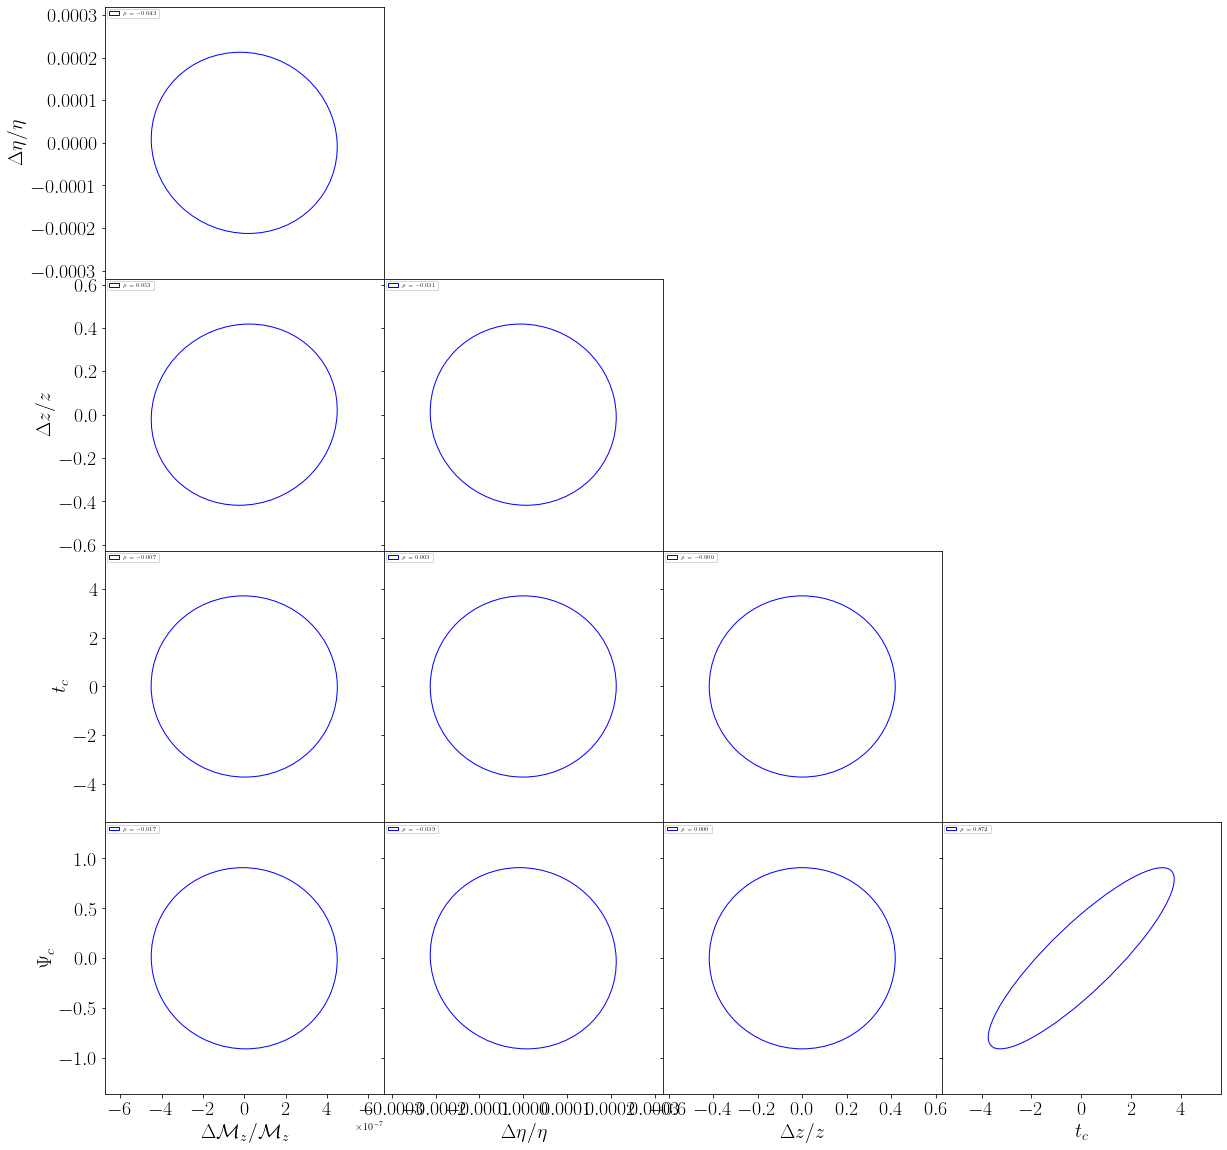

In [106]:
#make Fisher plot for LISA constraints
labels_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(len(fid_vals_GR)-1, len(fid_vals_GR)-1, hspace=0, wspace=0)

add_fisher_plots(cov_matrix_lisa,fid_vals_GR,labels_GR,'GR LISA','b')

In [107]:
label_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

data_ligo = np.random.multivariate_normal(fid_vals_GR, cov_matrix_ligo, size=20000)
data_lisa = np.random.multivariate_normal(fid_vals_GR, cov_matrix_lisa, size=20000)

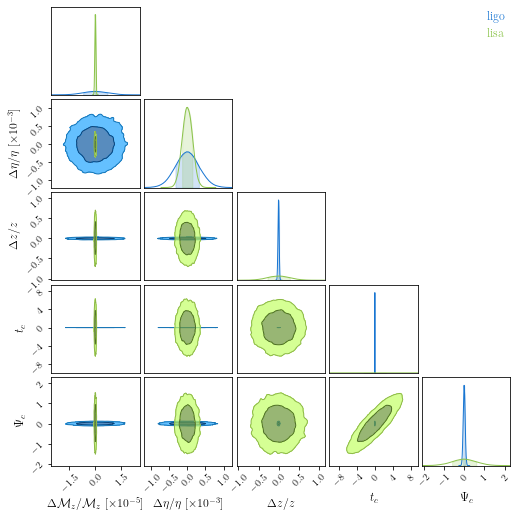

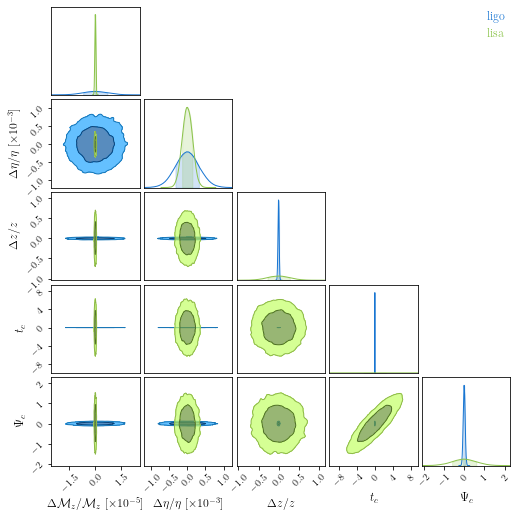

In [108]:
cc = ChainConsumer()
cc.add_chain(data_ligo, bins=30, smooth=True, parameters=label_GR, name='ligo')
cc.add_chain(data_lisa, bins=30, smooth=True, parameters=label_GR,name='lisa')
cc.plotter.plot()

# Step function

In [128]:
# Set parameters for step
fstar = 0.8
c0 = 0.9
w1 = 0.5


In [129]:
# Evaluate and plot Delta
cT_step_fo_w1 = utilities.cT_step(farr, fstar, c0, w1)
cT_step_fs_w1 = utilities.cT_step(farr*(1+zem), fstar, c0, w1)
Delta_step_w1 = 1-cT_step_fo_w1/cT_step_fs_w1

Text(0, 0.5, '$\\Delta$')

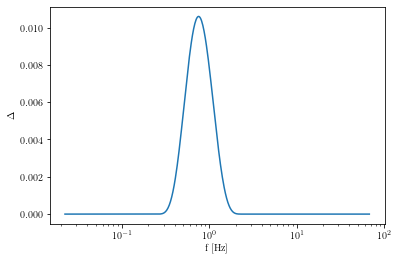

In [130]:
plt.semilogx(farr, Delta_step_w1)
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Delta$')

In [131]:
# Set parameters for runs and evaluate
pars_step = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]
pars_step_fid = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 1., fstar]

# For plotting only
h_Delta_step_w1 = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step, cosmo_params)
h_Delta_step_w1_fid = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step_fid, cosmo_params)
h_Delta_step_w1_fid_nodist = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step_fid, cosmo_params,dist_corr=False)

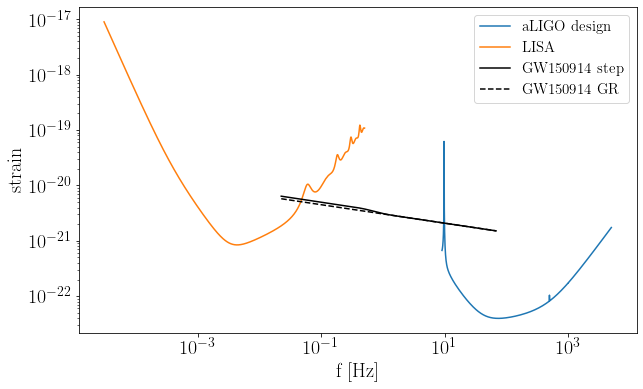

In [132]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(farr, np.abs(farr*h_Delta_step_w1), color='k', label='GW150914 step')
plt.loglog(farr, np.abs(farr*h_GR), color='k', label='GW150914 GR', linestyle='--')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('../plots/amp_psd_step.pdf')

In [133]:
mask_ligo = (farr>ligo_asd[0,0]) & (farr<=ligo_asd[-1,0])
mask_lisa = (farr>LISA_strain[0,0]) & (farr<=LISA_strain[-1,0])

ligo_psd = ligo_interp(farr[mask_ligo])**2
lisa_psd = lisa_interp(farr[mask_lisa])

In [134]:
# SNR for fiducial and non-fiducial models
SNR_ligo_sq = utilities.scalar_product(h_Delta_step_w1[mask_ligo], h_Delta_step_w1[mask_ligo], ligo_psd, farr[mask_ligo])
SNR_ligo_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid[mask_ligo], h_Delta_step_w1_fid[mask_ligo], ligo_psd, farr[mask_ligo])
SNR_ligo_step = np.sqrt(SNR_ligo_sq)
SNR_ligo_step_fid = np.sqrt(SNR_ligo_sq_fid)

SNR_lisa_sq = utilities.scalar_product(h_Delta_step_w1[mask_lisa], h_Delta_step_w1[mask_lisa], lisa_psd, farr[mask_lisa])
SNR_lisa_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid[mask_lisa], h_Delta_step_w1_fid[mask_lisa], lisa_psd, farr[mask_lisa])
SNR_lisa_step = np.sqrt(SNR_lisa_sq)
SNR_lisa_step_fid = np.sqrt(SNR_lisa_sq_fid)

print('LIGO SNR, mod and fiducial')
print(SNR_ligo_step,SNR_ligo_step_fid)
print('LISA SNR, mod and fiducial')
print(SNR_lisa_step,SNR_lisa_step_fid)

LIGO SNR, mod and fiducial
65.53013936673959 65.53013936673959
LISA SNR, mod and fiducial
3.8139043858285664 3.432516443843825


In [135]:
# Constraints for fiducial and non-fiducial models
cov_matrix_lisa_step = Fisher_det(farr[mask_lisa], pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=True)
cov_matrix_lisa_step_distcorr = Fisher_det(farr[mask_lisa], pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=False)
cov_matrix_lisa_step_fid = Fisher_det(farr[mask_lisa], pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=True)
cov_matrix_lisa_step_fid_distcorr = Fisher_det(farr[mask_lisa], pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, distcorr=False)

pconstraints_lisa_step = np.sqrt(np.diag(cov_matrix_lisa_step))
pconstraints_lisa_step_fid = np.sqrt(np.diag(cov_matrix_lisa_step_fid))
pconstraints_lisa_step_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_distcorr))
pconstraints_lisa_step_fid_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_fid_distcorr))

print('LISA step function')
print('mod')
print(pconstraints_lisa_step)
print('mod with distcorr')
print(pconstraints_lisa_step_distcorr)
print('fiducial')
print(pconstraints_lisa_step_fid)
print('fiducial with dist corr')
print(pconstraints_lisa_step_fid_distcorr)


(194,) (194,) (194,)
condition number (div by 1e15) 0.07021267763419307
(194,) (194,) (194,)
condition number (div by 1e15) 0.07021267763419307
(194,) (194,) (194,)
condition number (div by 1e15) 0.07541579652680301
(194,) (194,) (194,)
condition number (div by 1e15) 0.07541579652680301
LISA step function
mod
[2.86268602e-07 1.17899479e-04 9.59507276e-07 2.22430677e+00
 5.51104659e-01 3.71511669e-07]
mod with distcorr
[2.86268602e-07 1.17899479e-04 9.59507276e-07 2.22430677e+00
 5.51104659e-01 3.71511669e-07]
fiducial
[2.94773836e-07 1.42269567e-04 2.78810774e-01 2.46208507e+00
 5.99971881e-01 4.28006167e-07]
fiducial with dist corr
[2.94773836e-07 1.42269567e-04 2.78810774e-01 2.46208507e+00
 5.99971881e-01 4.28006167e-07]


In [137]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step_fid = np.linalg.inv(cov_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc = copy.copy(Fisher_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_fixtc)

In [146]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step = np.linalg.inv(cov_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc = copy.copy(Fisher_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fixtc)

In [138]:
# Same for uncorrected version
Fisher_matrix_lisa_step_fid_distcorr = np.linalg.inv(cov_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc = copy.copy(Fisher_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_distcorr_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_distcorr_fixtc)

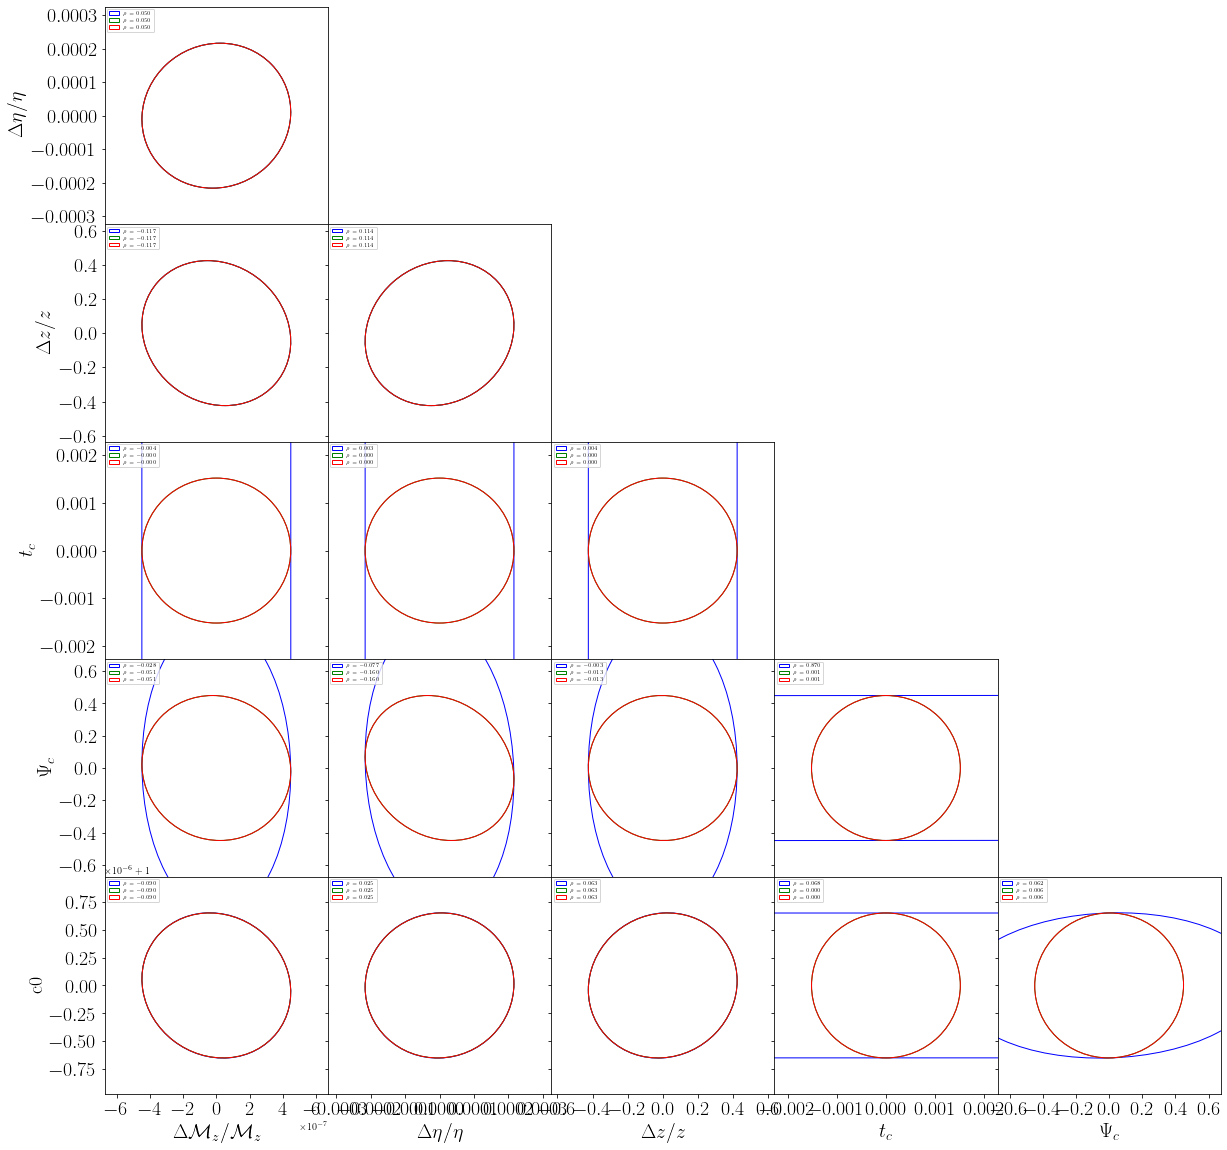

In [139]:
#make Fisher plot for LISA constraints with step fn
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']
fid_vals = [0,0,0,0,0,1]

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(len(fid_vals)-1, len(fid_vals)-1, hspace=0, wspace=0)

add_fisher_plots(cov_matrix_lisa_step_fid,fid_vals,label, 'vary tc',colour='b')
add_fisher_plots(cov_matrix_lisa_step_fid_fixtc,fid_vals,label,'fix tc',colour='g')
add_fisher_plots(cov_matrix_lisa_step_fid_distcorr_fixtc,fid_vals,label, 'fix tc no dist',colour='r')



In [151]:
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']
fid_vals = [0,0,0,0,0,1]
fid_vals_MG = [0,0,0,0,0,c0]

data = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid, size=20000)
data_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_fixtc, size=20000)
data_distcorr = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr, size=20000)
data_distcorr_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr_fixtc, size=20000)
data_MG = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step, size=20000)
data_MG_fixtc = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step_fixtc, size=20000)


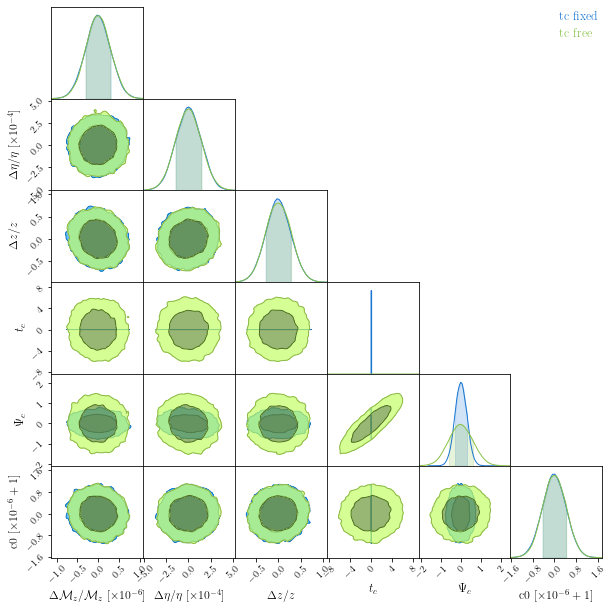

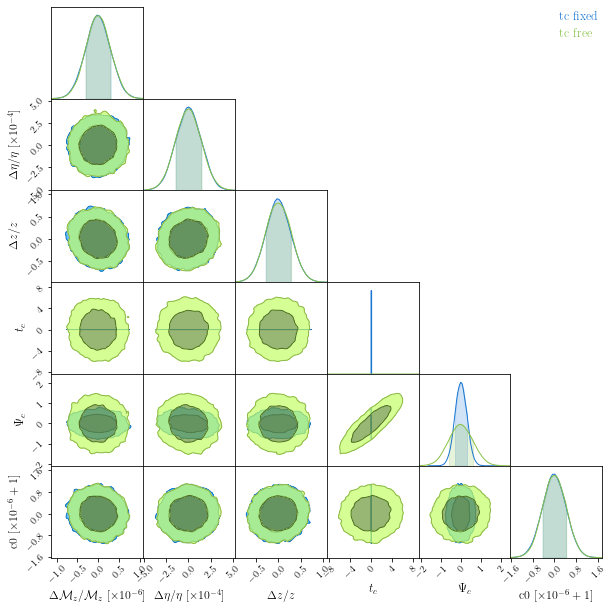

In [142]:
cc = ChainConsumer()
cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed')
cc.add_chain(data, bins=30, smooth=True, parameters=label, name='tc free')
cc.plotter.plot()


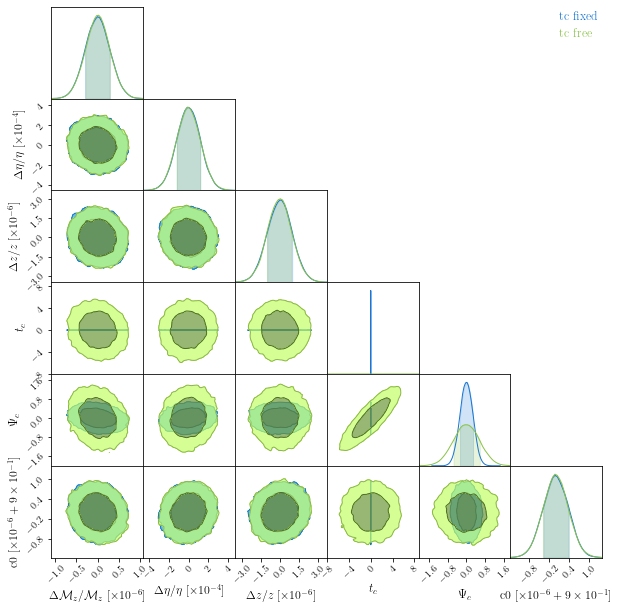

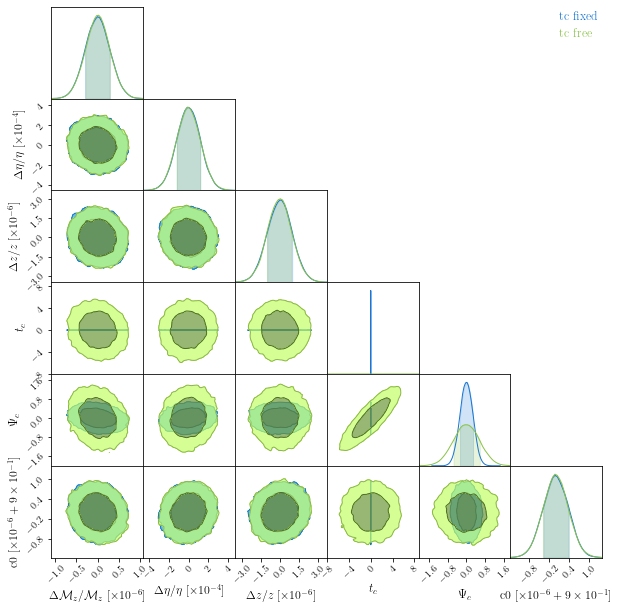

In [152]:
cc = ChainConsumer()
cc.add_chain(data_MG_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed')
cc.add_chain(data_MG, bins=30, smooth=True, parameters=label, name='tc free')
cc.plotter.plot()

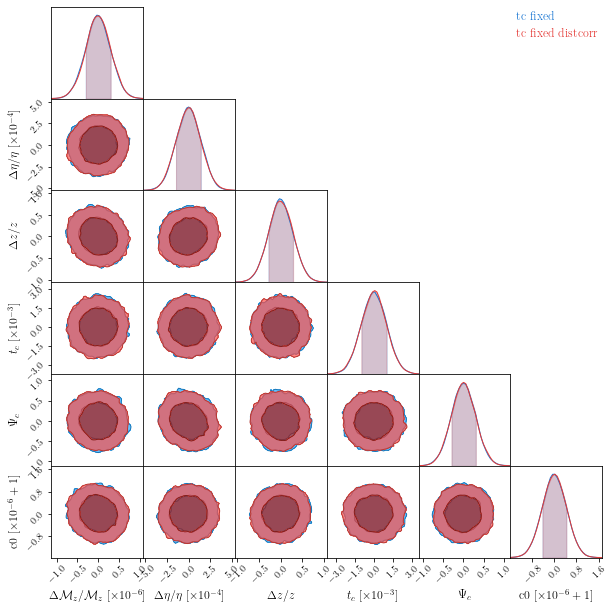

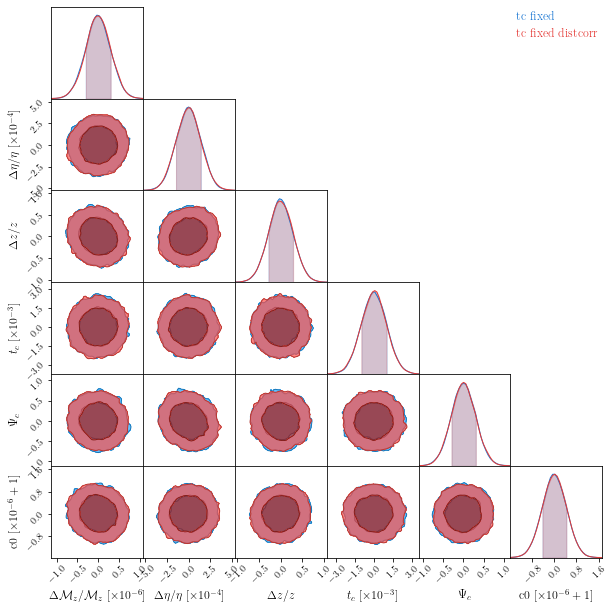

In [143]:
cc.remove_chain('tc free')

#cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label, name='tc fixed')
cc.add_chain(data_distcorr_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed distcorr',color='r')
cc.plotter.plot()

In [144]:
Psi, Psi_old = utilities.Psi_Delta_exact(farr, fstar, c0, Ms, eta, zem, cosmo_params, tc, psic, cT_type='step', width=w1)

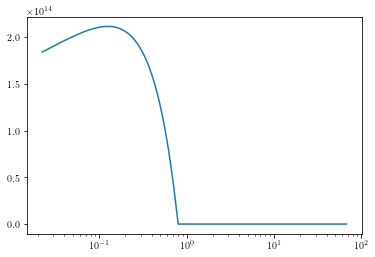

In [145]:
plt.semilogx(farr,abs(Psi/Psi_old))

In [127]:
cc.remove_chain('tc fixed')
cc.remove_chain('tc fixed distcorr')